In [1]:
# use Pytorch to code linear (k, d), radial basis function (c, mu, sigma) and neural network (10 hidden nodes) function approximator
# show GIF how it moves while trained with SGD for 1D mock data cloud (e.g. x^2 function on [0,1])

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

import sys
import time
from IPython.display import display, clear_output

import glob
import contextlib
from PIL import Image

%config InlineBackend.figure_formats = ['svg']

In [3]:
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.k = nn.Parameter(torch.tensor(0., requires_grad=True))
        self.d = nn.Parameter(torch.tensor(0., requires_grad=True))

    def forward(self, x):
        return self.k*x + self.d

In [4]:
class GaussianKernel(nn.Module):

    def __init__(self):
        super(GaussianKernel, self).__init__()
        self.A = nn.Parameter(torch.tensor(1., requires_grad=True))
        self.mu = nn.Parameter(torch.tensor(0., requires_grad=True))
        self.sigma = nn.Parameter(torch.tensor(0., requires_grad=True))

    def forward(self, x):
        return self.A*torch.exp(-(x - self.mu)**2/2/torch.exp(self.sigma)**2)

In [5]:
class Net(nn.Module):

    def __init__(self, nodes=100):
        super(Net, self).__init__()
        self.nodes = nodes
        self.fc1 = nn.Linear(1, nodes)
        self.fc2 = nn.Linear(nodes, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

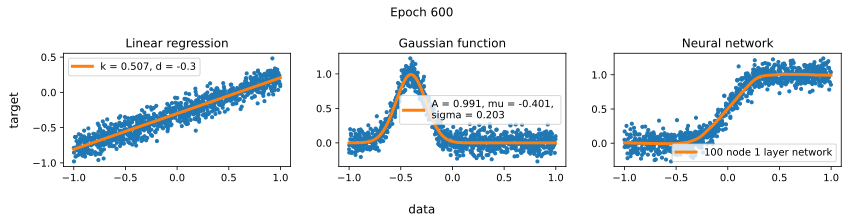

In [7]:
linear_model = LinearRegression()
gaussian_model = GaussianKernel()
net_model = Net()

data = torch.rand(1000)*2 - 1
linear_target = torch.normal(0.5*data - .3, .1*torch.ones(1000))
gaussian_target = torch.normal(torch.exp(-(data + .4)**2/2/.2**2), .1*torch.ones(1000))
net_target = torch.normal(1/(1 + torch.exp(-10*data)), .1*torch.ones(1000))

loss_function = nn.MSELoss()

optimizer_linear = torch.optim.SGD(linear_model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-5)
optimizer_gaussian = torch.optim.SGD(gaussian_model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-5)
optimizer_net = torch.optim.SGD(net_model.parameters(), lr=1e-2, momentum=0.9, weight_decay=1e-5)

losses = {'linear':[], 'gaussian':[], 'net':[]}

plot = True

for epoch in range(1,601):
    
    if epoch % 10 == 0 and plot:
        clear_output(wait=True)

        fig, axes = plt.subplots(1,3,figsize=(12,3))

        axes[0].scatter(data,linear_target, s=10)
        axes[0].plot(data.sort().values,linear_model(data.sort().values).detach().numpy(), color='C1', linewidth=3, 
                 label='k = {:.3}, d = {:.3}'.format(linear_model.k.item(), linear_model.d.item()))
        axes[0].set_title('Linear regression')
        axes[0].legend()

        axes[1].scatter(data,gaussian_target, s=10)
        axes[1].plot(data.sort().values,gaussian_model(data.sort().values).detach().numpy(), color='C1', linewidth=3, 
                 label='A = {:.3}, mu = {:.3}, \nsigma = {:.3}'.format(gaussian_model.A.item(), gaussian_model.mu.item(), np.exp(gaussian_model.sigma.item())))
        axes[1].set_title('Gaussian function')
        axes[1].legend()

        axes[2].scatter(data,net_target, s=10)
        axes[2].plot(data.sort().values,net_model(data.sort().values.reshape(1,-11)).flatten().detach().numpy(), color='C1', linewidth=3, 
                 label='{} node 1 layer network'.format(net_model.nodes))
        axes[2].set_title('Neural network')
        axes[2].legend()

        fig.supxlabel('data')
        fig.supylabel('target')
        plt.suptitle('Epoch {}'.format(epoch))
        plt.tight_layout()
        plt.savefig('4_plots/approximators_{}.png'.format(epoch), dpi=200)
        plt.show()

    optimizer_linear.zero_grad()
    loss = loss_function(linear_model(data), linear_target)
    loss.backward()
    optimizer_linear.step()
    losses['linear'].append(loss.item())

    optimizer_gaussian.zero_grad()
    loss = loss_function(gaussian_model(data), gaussian_target)
    loss.backward()
    optimizer_gaussian.step()
    losses['gaussian'].append(loss.item())

    optimizer_net.zero_grad()
    loss = loss_function(net_model(data.reshape(1,-1)), net_target.reshape(1,-1))
    loss.backward()
    optimizer_net.step()
    losses['net'].append(loss.item())


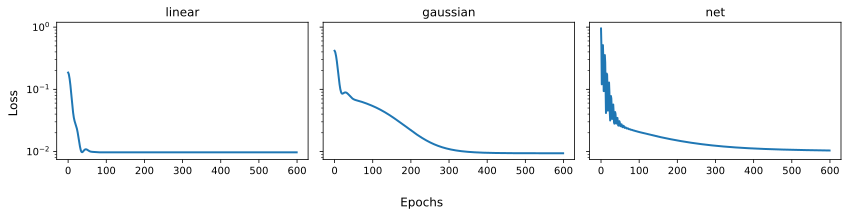

In [8]:
fig, axes = plt.subplots(1,3,figsize=(12,3), sharey=True, sharex=True)

axes[0].plot(losses['linear'],linewidth=2)
axes[0].set_yscale('log')
axes[0].set_title('linear')

axes[1].plot(losses['gaussian'],linewidth=2)
axes[1].set_yscale('log')
axes[1].set_title('gaussian')

axes[2].plot(losses['net'],linewidth=2)
axes[2].set_yscale('log')
axes[2].set_title('net')

fig.supxlabel('Epochs')
fig.supylabel('Loss')
plt.tight_layout()
plt.show()

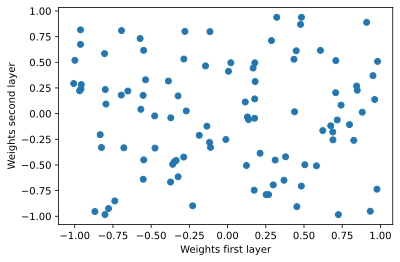

In [9]:
weights = [w.flatten().detach().numpy() for w in net_model.fc1.parameters()]
plt.scatter(weights[0], weights[1])
plt.xlabel('Weights first layer')
plt.ylabel('Weights second layer')
plt.show()

In [11]:
with contextlib.ExitStack() as stack:

    imgs = [stack.enter_context(Image.open(f"4_plots/approximators_{f}.png"))
            for f in range(10,600,10)]

    imgs[0].save(fp="4_plots/approximators.gif", format='GIF', append_images=imgs[1:],
             save_all=True, disposal=2, duration=200, loop=0)